<a href="https://colab.research.google.com/github/ttahiat/EMG_SIgnal_Classification/blob/main/Classification_Algorithms_EMG_Signal_Processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In order to start the classification we must first link the reprository which in this case is the drive folder.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Next, all the necessary libraries are imported.

In [2]:
import matplotlib.pyplot as plt
import scipy.io
import numpy as np
import pandas as pd
import os
import pywt
import mpmath
import seaborn as sns
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score

Each Subject file is then parsed and three different movenments are classified

In [3]:
file_paths = [
    '/content/drive/MyDrive/Dataset/Ninapro_DB5/S1_E1_A1.mat',
    '/content/drive/MyDrive/Dataset/Ninapro_DB5/S1_E2_A1.mat',
    '/content/drive/MyDrive/Dataset/Ninapro_DB5/S1_E3_A1.mat'
]

Function to extract information from the .mat files and store them in a dataframe

In [4]:
def extract_data(file_path,n):
    # Load the .mat file
    mat = scipy.io.loadmat(file_path)
    emg = mat['emg']
    grasp = mat['exercise']

    # Create DataFrame
    df = pd.DataFrame(emg, columns=[f'EMG{i+1}' for i in range(16)])
    df['grasp'] = n

    # Reset the index of the resampled DataFrame
    df = df.reset_index(drop=True)
    return df

Combining the files together into one dataframe

In [5]:
n=0
resampled_dfs = []
for file_path in file_paths:
    n=n+1
    resampled_data = extract_data(file_path,n)
    resampled_dfs.append(resampled_data)

combined_df = pd.concat(resampled_dfs, ignore_index=True)

print("Combined DataFrame:")
print(combined_df.shape)
print(combined_df.head(5))
df = combined_df

Combined DataFrame:
(568540, 17)
   EMG1  EMG2  EMG3  EMG4  EMG5  EMG6  EMG7  EMG8  EMG9  EMG10  EMG11  EMG12  \
0 -22.0  -2.0 -16.0  -7.0  -3.0  -1.0  -2.0  -4.0  -2.0  -46.0  -49.0   -5.0   
1   5.0  -4.0 -12.0  -3.0   8.0  25.0   1.0   1.0  -2.0   66.0   28.0    3.0   
2  -6.0   1.0   4.0  -1.0  -9.0   0.0 -10.0  -3.0  -9.0  -52.0  -24.0   -2.0   
3  15.0  10.0  19.0   9.0  10.0   7.0   2.0   1.0  -4.0  -13.0   19.0    4.0   
4  -1.0 -16.0 -17.0   0.0  -2.0  -7.0   2.0   0.0  -6.0   27.0    7.0   -1.0   

   EMG13  EMG14  EMG15  EMG16  grasp  
0    9.0    1.0   -1.0   -2.0      1  
1   22.0   10.0    2.0    1.0      1  
2  -52.0  -14.0  -24.0   -3.0      1  
3   28.0    6.0   -5.0  -12.0      1  
4  -22.0   -2.0   -7.0   15.0      1  


## Distribution of Grasp


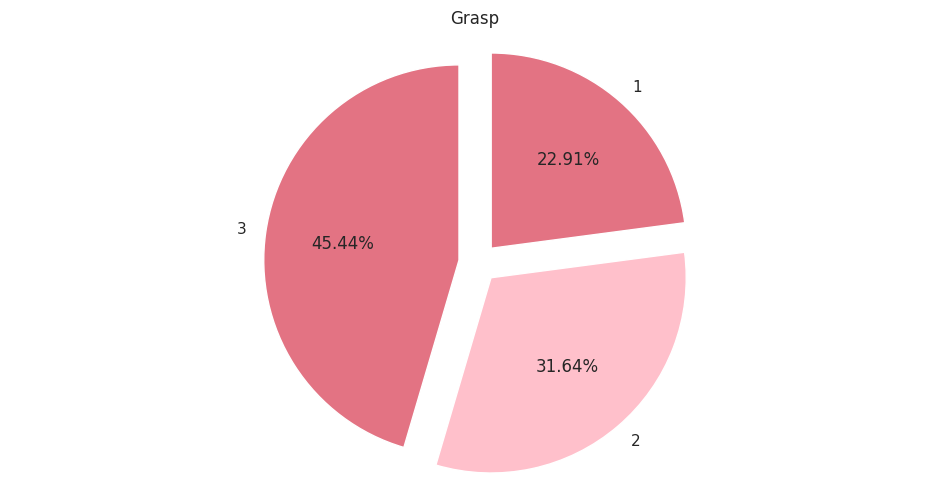

In [6]:
sns.set(style='whitegrid')

plt.figure(figsize=(12, 6))

grasp_counts = combined_df["grasp"].value_counts()

labels = grasp_counts.index.tolist()
counts = grasp_counts.values.tolist()

explode = [0.1] * len(labels)  # Adjust as needed

plt.pie(counts, labels=labels, explode=explode, autopct='%1.2f%%', colors=['#E37383', '#FFC0CB'], startangle=90)
plt.title('Grasp')
plt.axis('equal')
plt.show()

Check whether there are any null emg signal columns

In [7]:
df.isnull().sum(axis = 0)

EMG1     0
EMG2     0
EMG3     0
EMG4     0
EMG5     0
EMG6     0
EMG7     0
EMG8     0
EMG9     0
EMG10    0
EMG11    0
EMG12    0
EMG13    0
EMG14    0
EMG15    0
EMG16    0
grasp    0
dtype: int64

To avoid bais the number of samples for each movenment is kept the same

In [8]:
grasp_counts = df['grasp'].value_counts()

min_count = grasp_counts.min()

resampled_df = pd.DataFrame()
resampled_df = df.groupby('grasp').apply(lambda x: x.sample(n=min_count, random_state=42))
resampled_df = resampled_df.reset_index(drop=True)

df=resampled_df

Grasp distribution after resampling

In [9]:
df['grasp'].value_counts(sort=1)

grasp
1    130267
2    130267
3    130267
Name: count, dtype: int64

In [10]:
df.head(3)

,EMG1,EMG2,EMG3,EMG4,EMG5,EMG6,EMG7,EMG8,EMG9,EMG10,EMG11,EMG12,EMG13,EMG14,EMG15,EMG16,grasp
0,0.0,9.0,0.0,0.0,1.0,10.0,0.0,-1.0,-4.0,-1.0,2.0,-2.0,0.0,-1.0,-1.0,-4.0,1
1,-1.0,-5.0,4.0,-1.0,-1.0,0.0,-2.0,1.0,-2.0,-2.0,-1.0,0.0,-2.0,-3.0,-2.0,-3.0,1
2,-3.0,-2.0,0.0,0.0,1.0,3.0,-11.0,2.0,-3.0,-2.0,-3.0,-1.0,-1.0,-7.0,-1.0,-3.0,1


Feature Extraction Funtion of Four Time Domain Features

In [11]:
window_length = 200
overlap = int(window_length * 0.90)
sc = StandardScaler()
le = LabelEncoder()


def extract_feature_dataset(dataframe, window_length=200, overlap=overlap):
    column_df = pd.DataFrame()
    for col in range(16):
        grasp_df = pd.DataFrame()
        for grasp_value in range(1, 4):
            grasp_rows = dataframe[dataframe['grasp'] == grasp_value]
            # Sliding window approach for time domain feature extraction
            window_features_df = pd.DataFrame()
            window_features = []

            for start in range(0, len(grasp_rows) - window_length + 1, overlap):
                end = start + window_length
                window = grasp_rows[start:end]
                window_v = window.iloc[:, col]
                window_v = window_v.reset_index(drop=True)
                window_v = window_v.values.astype(mpmath.mpf)

                rms = np.sqrt(np.mean(window_v ** 2))
                mav = np.mean(np.abs(window_v))
                std = np.std(window_v)
                waveform_length = np.sum(np.abs(np.diff(window_v)))

                window_features.extend([rms, mav, std, waveform_length])

            window_rows = []

            for i in range(0, len(window_features),4): #5
                row = {
                    f'rms{col+1}': window_features[i],
                    f'mav{col+1}': window_features[i+1],
                    f'std{col+1}': window_features[i+2],
                    f'waveform_length{col+1}': window_features[i+3],
                    }

                window_rows.append(row)

            window_features_df = pd.DataFrame(window_rows)
            window_features_df['grasp'] = grasp_value
            grasp_df = pd.concat([grasp_df, window_features_df], ignore_index=True)

        column_df = pd.concat([column_df, grasp_df], axis=1)

    column_df.reset_index(drop=True, inplace=True)

    return column_df

Time domain feature dataset

In [14]:
df_200 = extract_feature_dataset(df,window_length=200)
df_200 = df_200.loc[:, ~df_200.columns.duplicated()]

Y_200 = df_200['grasp'].to_frame()
Y_200 = le.fit_transform(Y_200)

df_200 = df_200.drop('grasp',axis=1)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [15]:
sc = StandardScaler()
X = sc.fit_transform(df_200)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_200, test_size=0.2)

print(X.shape)
print(Y_200.shape)
print(Y_200)

(2169, 64)
(2169,)
[0 0 0 ... 2 2 2]


ExtraTrees Classifier

In [16]:
model = ExtraTreesClassifier(n_estimators=400, min_samples_split=2, max_depth=10, max_features='log2', random_state=42)
model.fit(X_train, Y_train)

prediction_train = model.predict(X_train)
prediction_test = model.predict(X_test)

accuracy_train = accuracy_score(Y_train, prediction_train)
accuracy_test = accuracy_score(Y_test, prediction_test)

print(f"ExtraTree - Train Accuracy: {accuracy_train:.4f}, Test Accuracy: {accuracy_test:.4f}")

ExtraTree - Train Accuracy: 1.0000, Test Accuracy: 0.9908


XGB Classifier

In [18]:
model = model = xgb.XGBClassifier(n_estimators=200, max_depth=7, learning_rate=0.05)
model.fit(X_train, Y_train)

prediction_train = model.predict(X_train)
prediction_test = model.predict(X_test)

accuracy_train = accuracy_score(Y_train, prediction_train)
accuracy_test = accuracy_score(Y_test, prediction_test)

print(f"XGB - Train Accuracy: {accuracy_train:.4f}, Test Accuracy: {accuracy_test:.4f}")

XGB - Train Accuracy: 1.0000, Test Accuracy: 0.9908


Random Forest Classifier

In [19]:
model = RandomForestClassifier(n_estimators=200, max_depth=7)
model.fit(X_train, Y_train)

prediction_train = model.predict(X_train)
prediction_test = model.predict(X_test)

accuracy_train = accuracy_score(Y_train, prediction_train)
accuracy_test = accuracy_score(Y_test, prediction_test)

print(f"Random Forest - Train Accuracy: {accuracy_train:.4f}, Test Accuracy: {accuracy_test:.4f}")


Random Forest - Train Accuracy: 1.0000, Test Accuracy: 0.9908


Random Forest Classifier without feature extraction

In [20]:
df_downsampled = df
X = df_downsampled
Y = X['grasp'].to_frame().values
X = X.drop('grasp',axis=1).values

X = sc.fit_transform(X)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

print(X.shape)
print(Y.shape)

model = RandomForestClassifier(n_estimators=200, max_depth=7)
model.fit(X_train, Y_train)

prediction_train = model.predict(X_train)
prediction_test = model.predict(X_test)

accuracy_train = accuracy_score(Y_train, prediction_train)
accuracy_test = accuracy_score(Y_test, prediction_test)

print(f"Random Forest - Train Accuracy: {accuracy_train:.4f}, Test Accuracy: {accuracy_test:.4f}")

(390801, 16)
(390801, 1)


<ipython-input-20-b8100c0f1d7f>:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, Y_train)


Random Forest - Train Accuracy: 0.4683, Test Accuracy: 0.4664
